# "Drop Number One" analysis

This is a modification of the "Drop One Variable" analysis that drops the top-ranked observation(s) instead of the series of input variables. This analysis tests the leverage of the "most vulnerable" observation on the net contributions of input variables to SoVI as well as the changes in index rank among US counties. If the index is robust to the leverage of individual observations, we expect to see minimal reshuffling of variable influence/county ranks when the top-ranked observation is dropped.

In [1]:
import os
import pandas as pd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import zscore as ZSCORE
from scipy.stats import rankdata
from scipy.stats import spearmanr 

# sovi compute script
import sys
sys.path.append(os.path.join(os.getcwd(),'code'))
from spss_pca import SPSS_PCA
import compute_sovis

C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


did not pull supplementary ACS data - A


C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 7 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: g02016, g15001, g15003, g15007, g25019, g36085, g53055
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 'g02016', ' is an island (no neighbors)')
('WARNING: ', 'g15001', ' is an island (no neighbors)')
('WARNING: ', 'g15003', ' is an island (no neighbors)')
('WARNING: ', 'g15007', ' is an island (no neighbors)')
('WARNING: ', 'g25019', ' is an island (no neighbors)')
('WARNING: ', 'g36085', ' is an island (no neighbors)')
('WARNING: ', 'g53055', ' is an island (no neighbors)')


## Methods

#### Some prep: 

In [2]:
#Get attribute names
attr_names=[j[0] for j in compute_sovis.input_names]

(Some of the stuff in the cell below might be removable. I just kept it all for now to make sure everything was in place for running SoVI...)

In [3]:
# rather than populating the `netContrib` object
# we can just use the final var contributions from 
# `compute_sovis`...
netContrib=compute_sovis.variable_contributions

#reorder table        
cols = ['USA', 'FEMA_1', 'g23g33g25', 
'FEMA_2', 'g36','FEMA_3', 'g51', 'FEMA_4', 'g13', 'FEMA_5', 'g17',
'FEMA_6', 'g48', 'FEMA_7', 'g29', 'FEMA_8', 'g46', 'FEMA_9', 'g06', 'FEMA_10', 
'g16']
netContrib = netContrib[cols]

#variable rank using absolute value      
rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
rankContrib = (28-rankContrib) + 1

combContrib = pd.DataFrame(columns=list(netContrib.columns), index=list(netContrib.index))
#can't think of a more elegant way to do this
for aRow in range(netContrib.shape[1]):
    for aCol in range(netContrib.shape[0]):
        combContrib.ix[aCol][aRow] = str(round(netContrib.ix[aCol][aRow], 2)) + ' (' + str(int(rankContrib.ix[aCol][aRow])) + ')'

#build list of varIDs and human readable names
#sort and use as index for conContrib
nameSort = [[name, hrname] for name, sign, sample, hrname in compute_sovis.input_names]
nameSort = pd.DataFrame(nameSort)
nameSort.index = nameSort.loc[:,0]
nameSort = nameSort.reindex(list(combContrib.index))    
    
#set descriptive names
combContrib.index = list(nameSort.loc[:,1])

# # write out results
# combContrib

Get the index of the "most vulnerable" county in the USA according to SoVI (Bronx, NY), and generate a version of the SoVI inputs with it dropped:

In [4]:
# get the index of the 
# "most vulnerable" county in USA
# as a side note, it's Bronx, NY
sovi_no1=compute_sovis.US_Sovi_Score[compute_sovis.US_Sovi_Score['rank']==compute_sovis.US_Sovi_Score['rank'].min()].index

In [5]:
# the data without Bronx
US_drop_no1=compute_sovis.US_All.drop(sovi_no1)

Preserve the original net contribution and county ranks. These will be used to compute changes in net contribution/county rank once SoVI is recomputed:

In [6]:
# These are still needed for computing change in rank...

#Construct table to hold the results of the drop one analysis
#Sort variable list based on importance rank.
USvarRanks = rankContrib.USA.copy() #have to make a copy to sort index
USvarRanks.sort('USA')
# dropLevels = USvarRanks.index

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [7]:
# preserve the original county ranks
# also for computing change in rank...
orig_rank=compute_sovis.US_Sovi_Score.drop(sovi_no1)['rank']

#### Now let's recompute SoVI with Bronx, NY dropped:

In [8]:
# preserve GEOIDs as an index
# for computed SoVI
geoLevels=US_drop_no1.Geo_FIPS

#Compute drop "number one"
pca = SPSS_PCA(US_drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
sovi_actual = pca.scores_rot.sum(1)
sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
US_SoVI_Drop1_Score = sovi_actual.values # SoVI score

In [9]:
# add SoVI ranks for run
# any way to clean this up?
US_SoVI_Drop1_Rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)

In [10]:
# check indices match
sum(US_SoVI_Drop1_Rank.index==orig_rank.index)

3142

Recompute net variable contribution:

In [11]:
attrib_contribution = pd.Series(data=pca.weights_rot.sum(1), index=US_drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
#print(j +" " + str(np.isnan(attrib_contribution.values).sum()))
attrib_contribution = attrib_contribution.transpose()

# attrib_contribution.index = [j]
#print(attrib_contribution.loc[j,:])
US_Drop1_NetContrib = attrib_contribution #.values
US_Drop1_NetContrib=US_Drop1_NetContrib.rank(ascending=False)
US_Drop1_NetContrib=US_Drop1_NetContrib.convert_objects(convert_numeric=True)
US_Drop1_NetContrib = US_Drop1_NetContrib.apply(lambda x: np.round(x, 2))

US_Drop1_NetContrib=US_Drop1_NetContrib[USvarRanks.index] # sort values by original index ranking

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Results

#### Net Contribution
Lots of small movements, and some larger ones for Percent African-American (`QBLACK_ACS`) and Percent of Housing in Mobile Homes (`QMOHO`), whose values drop considerably (-11 and -18, respectively).

In [12]:
nc_chg_dropno1=pd.DataFrame({'orig_rank':USvarRanks,'dropno1_rank':US_Drop1_NetContrib})
nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
nc_chg_dropno1

,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1.0,1.0,0.0
QFEMALE_ACS,2.0,2.0,0.0
QSERV_ALT,3.0,3.0,0.0
QHISP_ACS,4.0,4.0,0.0
QFEMLBR,5.0,5.0,0.0
QNATAM_ACS,6.0,6.0,0.0
QESL_ALT,7.0,7.0,0.0
QSSBEN,8.0,8.0,0.0
QNOAUTO_ALT,9.0,9.0,0.0
QMOHO,28.0,10.0,-18.0


#### County Rank Change
At first glance, it looks like there could be a lot of movement in the county ranks when Bronx, NY is left out of the data. For example, a couple of counties in Alabama, `g01001` and `g01007`, shift from near the top of the index (578, and 326, respectively) to near the bottom (2839 and 2973, respectively).

In [13]:
obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':US_SoVI_Drop1_Rank},index=orig_rank.index)
obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank
obs_rchg_drop1

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g01001,2839.0,578,-2261
g01003,2183.0,1900,-283
g01005,1578.0,3124,1546
g01007,2973.0,326,-2647
g01009,2470.0,1303,-1167
g01011,2606.0,976,-1630
g01013,244.0,520,276
g01015,1649.0,3020,1371
g01017,704.0,1435,731


C:\Users\Joe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


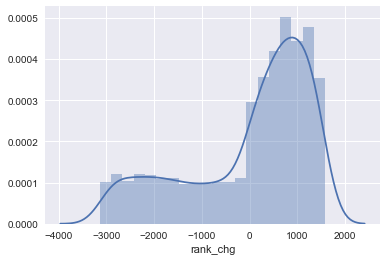

In [14]:
sns.distplot(obs_rchg_drop1.rank_chg)

### Map of Rank Changes
Just a simple `GeoPandas` choropleth to start...

In [35]:
import geopandas as gpd
from matplotlib.pylab import rcParams
import pysal as ps
rcParams['figure.figsize'] = 18, 15

In [16]:
sovi_map=gpd.read_file('data/spatial/USA_Counties_500k.shp')

In [17]:
# remove alaska and hawaii
sovi_map=sovi_map[~sovi_map['geoFIPS'].str.contains('g02') & ~sovi_map['geoFIPS'].str.contains('g15')]

In [18]:
# join the rank changes
obs_rchg_drop1['geoFIPS']=obs_rchg_drop1.index
sovi_map=pd.merge(sovi_map,obs_rchg_drop1,on='geoFIPS')

In [19]:
sovi_map.head()

,CENSUSAREA,COUNTY,GEO_ID,LSAD,NAME,STATE,geoFIPS,geometry,dropno1_rank,orig_rank,rank_chg
0,560.100,029,0500000US01029,County,Cleburne,01,g01029,"POLYGON ((-85.3887171312565 33.9130442466707, ...",1943.0,2445,502
1,678.972,031,0500000US01031,County,Coffee,01,g01031,"POLYGON ((-86.030441 31.618939, -86.0040849999...",2020.0,2255,235
2,650.926,037,0500000US01037,County,Coosa,01,g01037,"POLYGON ((-86.00927999999999 33.101638, -86.00...",2217.0,1843,-374
3,1030.456,039,0500000US01039,County,Covington,01,g01039,"POLYGON ((-86.3485063167533 30.994339155609, -...",804.0,1604,800
4,608.840,041,0500000US01041,County,Crenshaw,01,g01041,"POLYGON ((-86.146992 31.680455, -86.147114 31....",1846.0,2633,787


It is necessary before mapping to convert `rank_chg` to integer so that negative movements plot.

In [32]:
sovi_map.rank_chg=sovi_map.rank_chg.astype('int')

C:\Users\Joe\Anaconda3\lib\site-packages\geopandas\geodataframe.py:447: UserWarning: Unrecognized scheme "quantile". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)


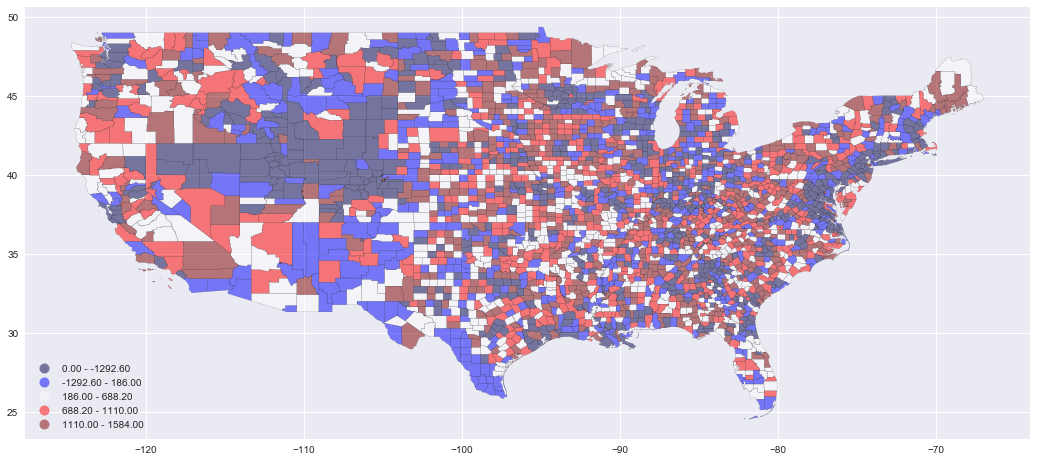

In [34]:
sovi_map.plot(column='rank_chg',cmap='seismic',linewidth=0.1,scheme='quantile',legend=True)

For some reason the breaks are not being plotted in order, maybe try binning instead?

In [39]:
ps.Equal_Interval(sovi_map.rank_chg,k=10)

                 Equal Interval                
 
  Lower              Upper                Count
            x[i] <= -2666.700               156
-2666.700 < x[i] <= -2194.400               159
-2194.400 < x[i] <= -1722.100               167
-1722.100 < x[i] <= -1249.800               152
-1249.800 < x[i] <=  -777.500               142
 -777.500 < x[i] <=  -305.200               151
 -305.200 < x[i] <=   167.100               293
  167.100 < x[i] <=   639.400               572
  639.400 < x[i] <=  1111.700               702
 1111.700 < x[i] <=  1584.000               614

In [92]:
# equal intervals
equint=ps.Equal_Interval(sovi_map.rank_chg,k=10)

In [93]:
# equal interval classes
equint.yb

array([7, 7, 5, ..., 0, 8, 1])

In [94]:
sovi_map.rank_chg.ix[np.where(equint.yb==7)].describe()

count    572.000000
mean     411.617133
std      142.515991
min      168.000000
25%      285.750000
50%      422.000000
75%      543.000000
max      639.000000
Name: rank_chg, dtype: float64

In [95]:
breaks_unique=np.unique(equint.yb)

In [145]:
def getLabels(inData,var,breaks,cl,inc=1):
    
    if cl==breaks.min(): # first entry
        return 'q'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl)].min())+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 
    else:
        return 'q'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl-1)].max()+inc)+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 

In [146]:
# all class labels
lab=[getLabels(sovi_map,'rank_chg',equint.yb,cl) for cl in breaks_unique]
lab

['q0 -3139 : -2667',
 'q1 -2666 : -2198',
 'q2 -2197 : -1724',
 'q3 -1723 : -1251',
 'q4 -1250 : -780',
 'q5 -779 : -308',
 'q6 -307 : 163',
 'q7 164 : 639',
 'q8 640 : 1111',
 'q9 1112 : 1584']

In [147]:
# lookup table for class labels
lab_lookup=pd.DataFrame({'break_class':breaks_unique,'label':lab})

The prefixes are kind of a workaround...

In [148]:
lab_lookup[lab_lookup['break_class']==0]['label'][0]

'q0 -3139 : -2667'

In [149]:
# the full set of labels
lab_obs=[lab_lookup[lab_lookup['break_class']==i]['label'][i] for i in equint.yb]
# lab_obs

In [150]:
sovi_map['label']=lab_obs

In [151]:
sovi_map.head()

,CENSUSAREA,COUNTY,GEO_ID,LSAD,NAME,STATE,geoFIPS,geometry,dropno1_rank,orig_rank,rank_chg,label
0,560.100,029,0500000US01029,County,Cleburne,01,g01029,"POLYGON ((-85.3887171312565 33.9130442466707, ...",1943.0,2445,502,q7 164 : 639
1,678.972,031,0500000US01031,County,Coffee,01,g01031,"POLYGON ((-86.030441 31.618939, -86.0040849999...",2020.0,2255,235,q7 164 : 639
2,650.926,037,0500000US01037,County,Coosa,01,g01037,"POLYGON ((-86.00927999999999 33.101638, -86.00...",2217.0,1843,-374,q5 -779 : -308
3,1030.456,039,0500000US01039,County,Covington,01,g01039,"POLYGON ((-86.3485063167533 30.994339155609, -...",804.0,1604,800,q8 640 : 1111
4,608.840,041,0500000US01041,County,Crenshaw,01,g01041,"POLYGON ((-86.146992 31.680455, -86.147114 31....",1846.0,2633,787,q8 640 : 1111


Now plot using the binned labels...

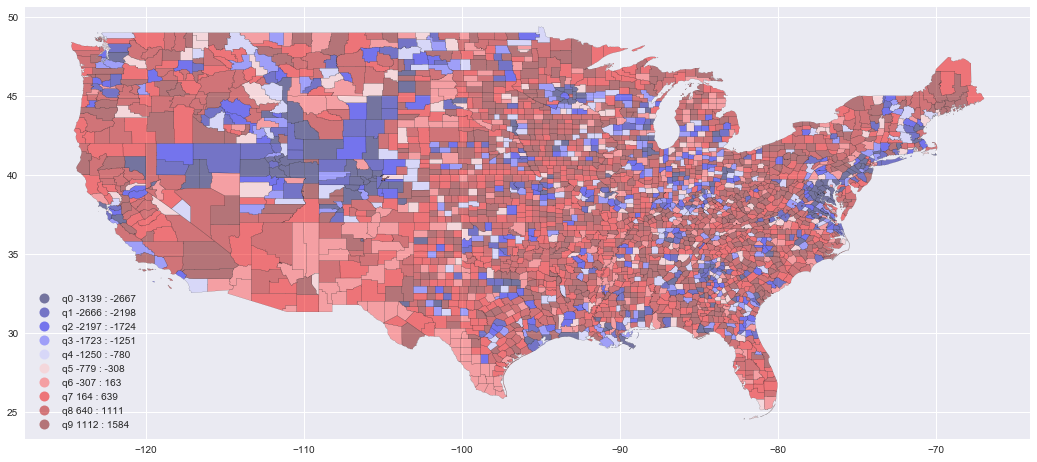

In [152]:
sovi_map.plot(column='label',cmap='seismic',linewidth=0.1,legend=True)

But upon further inspection, I think something is *at least* wrong with the original SoVI ranks...

In [153]:
sovi_map[sovi_map.geoFIPS=='g08013']

,CENSUSAREA,COUNTY,GEO_ID,LSAD,NAME,STATE,geoFIPS,geometry,dropno1_rank,orig_rank,rank_chg,label
236,726.289,013,0500000US08013,County,Boulder,08,g08013,"(POLYGON ((-105.05851 39.97449599999999, -105....",3064.0,167,-2897,q0 -3139 : -2667
